In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import eli5
import datetime as dt
import geopandas as gpd
from shapely import wkt

import itertools
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score, auc


from eli5.sklearn import PermutationImportance

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

## PART 1: Data Import & Cleaning

#### I obtained imagery data from NASA that I already had converted to tabular. Each observation in the dataset corresponds to a district in Sub Saharan Africa (think of a U.S. county). For each district, we have observations for every month on flooding, temperature, number of fatalites, population and rainfall. We will be adding more economic variable data as we proceed.

In [246]:
df = pd.read_csv("horn_panel_input.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,year,dis2_code,date,dis2_name,dis1_code,dis1_name,dis0_code,dis0_name,flooding,flood_area,temperature,fatalities,riots,protests,viol_against_civ,explosions,str_dev,total_incidents,battles,pop,drought,rainfall
0,0,0,2000,DJ0202,8/1/2000,Randa,DJ02,Tadjourah,DJI,Djibouti,NaN,NaN,31.593,0,0,0,0,0,0,0,0,14964.359,-0.110,35.901
1,1,1,2000,DJ0401,6/1/2000,Djibouti,DJ04,Djibouti,DJI,Djibouti,NaN,NaN,35.242,0,0,0,0,0,0,0,0,450333.062,-0.110,0.745
2,2,2,2000,DJ0203,5/1/2000,Balha,DJ02,Tadjourah,DJI,Djibouti,NaN,NaN,37.769,0,0,0,0,0,0,0,0,7422.979,-0.103,7.123
3,3,3,2000,DJ0202,9/1/2000,Randa,DJ02,Tadjourah,DJI,Djibouti,NaN,NaN,32.315,0,0,0,0,0,0,0,0,14964.359,-0.125,49.743
4,4,4,2000,DJ0301,7/1/2000,YobokiI,DJ03,Dilkhil,DJI,Djibouti,NaN,NaN,32.149,0,0,0,0,0,0,0,0,38817.105,-0.088,30.773


## Clean Initial Dataset

Here we set all variables in their right formats. 

In [247]:
df['date'] = pd.to_datetime(df['date'])
df['month']  = (df['date'].dt.month)
df['year']  = (df['date'].dt.year)

,Unnamed: 0.1,Unnamed: 0,year,dis2_code,date,dis2_name,dis1_code,dis1_name,dis0_code,dis0_name,flooding,flood_area,temperature,fatalities,riots,protests,viol_against_civ,explosions,str_dev,total_incidents,battles,pop,drought,rainfall,month
0,0,0,2000,DJ0202,2000-08-01,Randa,DJ02,Tadjourah,DJI,Djibouti,NaN,NaN,31.593,0,0,0,0,0,0,0,0,14964.359,-0.110,35.901,8
1,1,1,2000,DJ0401,2000-06-01,Djibouti,DJ04,Djibouti,DJI,Djibouti,NaN,NaN,35.242,0,0,0,0,0,0,0,0,450333.062,-0.110,0.745,6
2,2,2,2000,DJ0203,2000-05-01,Balha,DJ02,Tadjourah,DJI,Djibouti,NaN,NaN,37.769,0,0,0,0,0,0,0,0,7422.979,-0.103,7.123,5
3,3,3,2000,DJ0202,2000-09-01,Randa,DJ02,Tadjourah,DJI,Djibouti,NaN,NaN,32.315,0,0,0,0,0,0,0,0,14964.359,-0.125,49.743,9
4,4,4,2000,DJ0301,2000-07-01,YobokiI,DJ03,Dilkhil,DJI,Djibouti,NaN,NaN,32.149,0,0,0,0,0,0,0,0,38817.105,-0.088,30.773,7


In [248]:
# arrange
df = df.sort_values(["dis0_name", "dis1_name", "dis2_name", "date"], axis=0, ascending=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,year,dis2_code,date,dis2_name,dis1_code,dis1_name,dis0_code,dis0_name,flooding,flood_area,temperature,fatalities,riots,protests,viol_against_civ,explosions,str_dev,total_incidents,battles,pop,drought,rainfall,month
92,92,92,2000,DJ0501,2000-02-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,30.973,0,0,0,0,0,0,0,0,57553.438,-0.118,5.679,2
72,72,72,2000,DJ0501,2000-03-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,31.105,0,0,0,0,0,0,0,0,57553.438,-0.114,7.705,3
31,31,31,2000,DJ0501,2000-04-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,35.054,0,0,0,0,0,0,0,0,57553.438,-0.112,21.646,4
7,7,7,2000,DJ0501,2000-05-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,36.275,0,0,0,0,0,0,0,0,57553.438,-0.118,17.655,5
98,98,98,2000,DJ0501,2000-06-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,34.866,0,0,0,0,0,0,0,0,57553.438,-0.110,1.875,6


In [249]:
# make outcome variables
df['violent_incident'] = df['viol_against_civ'] + df['explosions'] + df['battles']
df['violent_incident'] = np.where(df['violent_incident'] > 0, 1, 0)

In [250]:
# make outcome variables
df['demonstration'] = df['riots'] + df['protests']
df['demonstration'] = np.where(df['demonstration'] > 0, 1, 0)

In [251]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' , 'riots', 'protests', 'str_dev', 'fatalities','viol_against_civ',
              'explosions', 'str_dev', 'total_incidents','battles'],axis=1)
df.head()

,year,dis2_code,date,dis2_name,dis1_code,dis1_name,dis0_code,dis0_name,flooding,flood_area,temperature,pop,drought,rainfall,month,violent_incident,demonstration
92,2000,DJ0501,2000-02-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,30.973,57553.438,-0.118,5.679,2,0,0
72,2000,DJ0501,2000-03-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,31.105,57553.438,-0.114,7.705,3,0,0
31,2000,DJ0501,2000-04-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,35.054,57553.438,-0.112,21.646,4,0,0
7,2000,DJ0501,2000-05-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,36.275,57553.438,-0.118,17.655,5,0,0
98,2000,DJ0501,2000-06-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,NaN,NaN,34.866,57553.438,-0.110,1.875,6,0,0


In [252]:
df = df.reset_index(drop = True)

## Linearly Interpolate Population (i.e., imputing with missing data)


#### These regions don't really have formal population counts. We are relying on UN estimates and those are not always complete. 

In [ ]:
# linearly interpolate population
# first, take log of population
df['log_pop'] = np.log(df['pop']) 

# get time variable
df['time'] = df.reset_index().index

In [254]:
# get unique list of dis2
unique_dis2 = df['dis2_code'].unique()

In [255]:
# generate predictions at dis2 level for population

full_predictions = []
for dis2 in unique_dis2:
    temp_dis2 = df[df['dis2_code'] == dis2]
    temp_dis2 = temp_dis2[['time', 'log_pop']]
    x_full = temp_dis2[['time']]
    
    # drop missing
    temp_dis2 = temp_dis2.dropna()
    
    X = temp_dis2[['time']]
    y = temp_dis2['log_pop']
    
    # get predictions
    predictions = LinearRegression().fit(X, y).predict(x_full)
    
    full_predictions.append(((predictions.tolist())))

In [256]:
full_predictions = pd.DataFrame(full_predictions) 

In [257]:
# make predictions long
full_predictions['dis2'] = full_predictions.reset_index().index
full_predictions_long = pd.melt(full_predictions,id_vars=['dis2'], var_name='time', value_name='values')
full_predictions_long = full_predictions_long.sort_values(["dis2", "time"], axis=0, ascending=True)
full_predictions_long = full_predictions_long.reset_index(drop = True)

In [258]:
# add predictions back into dataframe
df['log_pop_predict'] = full_predictions_long['values'] 

In [259]:
# use real population if available; otherwise use prediction
df['log_pop_impute'] = np.where(df.log_pop.isnull(), df['log_pop_predict'], df['log_pop'])

In [ ]:
# drop original population variables
df = df.drop(['pop', 'log_pop', 'log_pop_predict'],axis=1)

## Replace Missing Flood with 0s 

#### Flooding is an exogenous variable that cannot be imputed with the observations available in the dataset. Where we have missing information, we set it to zero. 

In [261]:
# replace flood with 0 if missing; add indicator variable if missing
df['flooding_missing'] = np.where(df.flooding.isnull(), 1, 0)
df['flood_area_missing'] = np.where(df.flood_area.isnull(), 1, 0)

In [262]:
# confirm only flood variables are missing
df.isnull().sum()

year                       0
dis2_code                  0
date                       0
dis2_name                  0
dis1_code                  0
dis1_name                  0
dis0_code                  0
dis0_name                  0
flooding              135020
flood_area            171030
temperature                0
drought                    0
rainfall                   0
month                      0
violent_incident           0
demonstration              0
time                       0
log_pop_impute             0
flooding_missing           0
flood_area_missing         0
dtype: int64

In [ ]:
# replace with nas
df = df.fillna(0)

## Add Ethnic Fractionalization Data 

In [264]:
hief = pd.read_csv("hief_data.csv")

In [265]:
# find country year combinations in full data set
country_year = df[['dis0_name', 'year']].drop_duplicates()
country_year = country_year.reset_index(drop = True)
# code South Sudan as Sudan to Match to hief
#country_year['Country'] = np.where(country_year['dis0_name'] == "South Sudan", "Sudan", country_year['dis0_name'])
# drop South Sudan, since it is not in the hief data
country_year = country_year[country_year.dis0_name != "South Sudan"]
country_year = country_year.rename(columns={"year":"Year", })
country_year['Country'] = country_year['dis0_name']

merged_hief = pd.merge(country_year, hief, how = "left")

In [267]:
countries = merged_hief['Country'].unique()

### Impute Data for ethnic fractionalization

In [268]:
# generate imputed ethnic fractionalization for each country 
full_predictions = []

for country in countries:
    temp_country = merged_hief[merged_hief['Country'] == country]
    
    temp_country = temp_country[['Year', 'EFindex']]
    x_full = temp_country[['Year']]
    
    # drop missing
    temp_country = temp_country.dropna()
    
    X = temp_country[['Year']]
    y = temp_country['EFindex']
    
    # get predictions
    predictions = LinearRegression().fit(X, y).predict(x_full)
    
    full_predictions.append(((predictions.tolist())))

In [269]:
full_predictions = pd.DataFrame(full_predictions)
full_predictions['Country'] = full_predictions.reset_index().index
full_predictions_long = pd.melt(full_predictions,id_vars=['Country'], var_name='Year', value_name='imputed_hief')
full_predictions_long = full_predictions_long.sort_values(["Country", "Year"], axis=0, ascending=True)
full_predictions_long = full_predictions_long.reset_index(drop = True)

In [270]:
merged_hief['predicted_hief'] = full_predictions_long['imputed_hief']
merged_hief['imputed_hief'] = np.where(merged_hief.EFindex.isnull(), merged_hief['predicted_hief'], merged_hief['EFindex'])
merged_hief = merged_hief.drop(['dis0_name', 'EFindex', 'predicted_hief'],axis=1)

In [ ]:
# be sure to match South Sudan with Sudan - change merge key here
df['Country'] = np.where(df['dis0_name'] == "South Sudan", "Sudan", df['dis0_name'])
merged_hief = merged_hief.rename(columns={"Year":"year"})
df = pd.merge(df, merged_hief, how = "left") 

## Add GDP Data 

In [272]:
country_year = country_year[country_year.dis0_name != "South Sudan"]

In [273]:
world_bank_gdp = pd.read_csv("world_bank_gdp.csv")
world_bank_gdp = world_bank_gdp.drop(['Country Code', 'Indicator Code', 'Indicator Name'], axis = 1)
world_bank_gdp.head()

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27511.336,27780.233,27966.488,30149.423,31421.641,30907.007,31205.361,33774.527,34254.135,35429.173,37366.695,38729.561,34393.257,33784.538,35513.081,34632.952,36830.157,36782.227,37314.564,37587.066,38893.961,40143.000,39834.224,31182.834,NaN
1,Africa Eastern and Southern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2049.995,2057.622,2090.946,2156.355,2227.889,2291.273,2351.059,2484.603,2651.414,2839.030,3030.356,3144.720,3107.568,3218.019,3323.273,3237.872,3365.684,3503.827,3533.337,3627.474,3670.891,3761.035,3814.847,3659.273,3881.592
2,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,876.328,928.192,925.704,1023.550,1078.907,1230.205,1273.788,1519.311,1710.763,1699.488,1914.774,2015.515,2069.424,2087.305,1981.118,2058.400,2082.392,2152.190,2078.479,NaN
3,Africa Western and Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1919.596,1957.926,1962.879,2025.096,2121.943,2297.086,2406.430,2596.971,2759.134,2915.292,3070.680,3233.803,3358.518,3532.530,3675.392,3772.324,4013.197,4208.732,4139.323,4069.006,4115.645,4231.321,4335.409,4241.522,4474.971
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3119.366,3197.526,3207.394,3271.270,3372.471,3765.609,3823.350,4208.039,4818.777,5344.224,6031.482,6584.875,6441.035,6588.835,6710.751,7412.967,7682.476,8179.298,7337.570,7103.226,7310.897,7148.933,6995.300,6478.332,6581.042


In [ ]:
world_bank_gdp_long = pd.melt(world_bank_gdp,id_vars=['Country Name'], var_name='Year', value_name='gdp_per_capita')
#full_predictions_long = full_predictions_long.sort_values(["dis2", "time"], axis=0, ascending=True)
#full_predictions_long = full_predictions_long.reset_index(drop = True)
world_bank_gdp_long = world_bank_gdp_long.rename(columns={"Country Name":"Country"})
world_bank_gdp_long['Year'] = world_bank_gdp_long['Year'].astype(int)

In [275]:
merged_gdp = pd.merge(country_year, world_bank_gdp_long, how = "left")

In [276]:
merged_gdp['log_gdp_per_capita'] = np.log(merged_gdp['gdp_per_capita'])

In [277]:
countries = merged_gdp['Country'].unique()

In [278]:
full_predictions = []

for country in countries:
    temp_country = merged_gdp[merged_gdp['Country'] == country]
    temp_country = temp_country[['Year', 'log_gdp_per_capita']]
    x_full = temp_country[['Year']]
    
    # drop missing
    temp_country = temp_country.dropna()
    
    X = temp_country[['Year']]
    y = temp_country['log_gdp_per_capita']
    
    # get predictions
    predictions = LinearRegression().fit(X, y).predict(x_full)
    
    full_predictions.append(((predictions.tolist())))

In [279]:
full_predictions = pd.DataFrame(full_predictions)

In [280]:
full_predictions['Country'] = full_predictions.reset_index().index
full_predictions_long = pd.melt(full_predictions,id_vars=['Country'], var_name='Year', value_name='predicted_log_gdp_pc')
full_predictions_long = full_predictions_long.sort_values(["Country", "Year"], axis=0, ascending=True)
full_predictions_long = full_predictions_long.reset_index(drop = True)

In [281]:
merged_gdp['predicted_log_gdp_pc'] = full_predictions_long['predicted_log_gdp_pc']
merged_gdp['log_gdp_impute'] = np.where(merged_gdp.log_gdp_per_capita.isnull(), merged_gdp['predicted_log_gdp_pc'], merged_gdp['log_gdp_per_capita'])
merged_gdp = merged_gdp.drop(['dis0_name', 'gdp_per_capita','log_gdp_per_capita','predicted_log_gdp_pc'],axis=1)

In [282]:
# add back to full data set
df['Country'] = np.where(df['dis0_name'] == "South Sudan", "Sudan", df['dis0_name'])

In [ ]:
merged_gdp = merged_gdp.rename(columns={"Year":"year"})
df = pd.merge(df, merged_gdp, how = "left") 

## Incorporate HDI

#### The Human Development Index is seen as a strong predictor for a country's economic, educational and health trajectory. The literature strongly suggests that these predictors are strongly correlated with the incidence of conflict. 

In [284]:
hdi_indices = pd.read_csv("hdi_indices.csv")

In [285]:
hdi_indices_long = pd.melt(hdi_indices,id_vars=['country'], var_name='year', value_name='hdi_index')
#full_predictions_long = full_predictions_long.sort_values(["dis2", "time"], axis=0, ascending=True)
#full_predictions_long = full_predictions_long.reset_index(drop = True)
hdi_indices_long = hdi_indices_long.rename(columns={"country":"Country", 'year':"Year"})
hdi_indices_long['Year'] = hdi_indices_long['Year'].astype(int)

In [286]:
merged_hdi = pd.merge(country_year, hdi_indices_long, how = "left")

In [287]:
#Data does not exist for Somalia
country_year = country_year[country_year.dis0_name != "Somalia"]
countries = countries[countries != "Somalia"]
merged_hdi = merged_hdi[merged_hdi['Country'] != "Somalia"]

In [288]:
countries 

array(['Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Sudan', 'Uganda'],
      dtype=object)

In [289]:
merged_hdi = merged_hdi.reset_index(drop = True)

In [290]:
full_predictions = []


#Make the predictions for missing HDI data 
for country in countries:
    temp_country = merged_hdi[merged_hdi['Country'] == country]
    temp_country = temp_country[['Year', 'hdi_index']]
    x_full = temp_country[['Year']]
    
    # drop missing
    temp_country = temp_country.dropna()
    
    X = temp_country[['Year']]
    y = temp_country['hdi_index']
    
    # get predictions
    predictions = LinearRegression().fit(X, y).predict(x_full)
    
    full_predictions.append(((predictions.tolist())))

In [292]:
full_predictions = pd.DataFrame(full_predictions)

In [293]:
full_predictions['Country'] = full_predictions.reset_index().index
full_predictions_long = pd.melt(full_predictions,id_vars=['Country'], var_name='Year', value_name='hdi_index')
full_predictions_long = full_predictions_long.sort_values(["Country", "Year"], axis=0, ascending=True)
full_predictions_long = full_predictions_long.reset_index(drop = True)

In [ ]:
merged_hdi['predicted_hdi_index'] = full_predictions_long['hdi_index']
merged_hdi['hdi_index_impute'] = np.where(merged_hdi.hdi_index.isnull(), merged_hdi['predicted_hdi_index'], merged_hdi['hdi_index'])
merged_hdi = merged_hdi.drop(['dis0_name', 'predicted_hdi_index','hdi_index'],axis=1)

In [297]:
# add back to full data set
df['Country'] = np.where(df['dis0_name'] == "South Sudan", "Sudan", df['dis0_name'])

In [298]:
#Merge the data together
merged_hdi = merged_hdi.rename(columns={"Year":"year"})
df = pd.merge(df, merged_hdi, how = "left") 


,year,dis2_code,date,dis2_name,dis1_code,dis1_name,dis0_code,dis0_name,flooding,flood_area,temperature,drought,rainfall,month,violent_incident,demonstration,time,log_pop_impute,flooding_missing,flood_area_missing,Country,imputed_hief,log_gdp_impute,hdi_index_impute
0,2000,DJ0501,2000-02-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,0.0,0.0,30.973,-0.118,5.679,2,0,0,0,10.960,1,1,Djibouti,0.651,7.739,0.361
1,2000,DJ0501,2000-03-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,0.0,0.0,31.105,-0.114,7.705,3,0,0,1,10.960,1,1,Djibouti,0.651,7.739,0.361
2,2000,DJ0501,2000-04-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,0.0,0.0,35.054,-0.112,21.646,4,0,0,2,10.960,1,1,Djibouti,0.651,7.739,0.361
3,2000,DJ0501,2000-05-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,0.0,0.0,36.275,-0.118,17.655,5,0,0,3,10.960,1,1,Djibouti,0.651,7.739,0.361
4,2000,DJ0501,2000-06-01,Ali Sabeh,DJ05,Ali Sabeh,DJI,Djibouti,0.0,0.0,34.866,-0.110,1.875,6,0,0,4,10.960,1,1,Djibouti,0.651,7.739,0.361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210375,2022,UG4135,2022-01-01,Sheema,UG4,Western,UGA,Uganda,0.0,0.0,20.900,-0.699,72.179,1,0,0,210375,12.435,1,1,Uganda,0.882,7.883,0.554
210376,2022,UG4135,2022-02-01,Sheema,UG4,Western,UGA,Uganda,0.0,0.0,20.328,-0.692,113.020,2,0,0,210376,12.436,1,1,Uganda,0.882,7.883,0.554
210377,2022,UG4135,2022-03-01,Sheema,UG4,Western,UGA,Uganda,0.0,0.0,21.687,-0.665,75.510,3,0,0,210377,12.437,1,1,Uganda,0.882,7.883,0.554
210378,2022,UG4135,2022-04-01,Sheema,UG4,Western,UGA,Uganda,0.0,0.0,20.660,-0.715,152.224,4,0,0,210378,12.438,1,1,Uganda,0.882,7.883,0.554


## Review Missing Data & Rename Variables

In [300]:
df.isnull().sum()
# missing for somalia

year                      0
dis2_code                 0
date                      0
dis2_name                 0
dis1_code                 0
dis1_name                 0
dis0_code                 0
dis0_name                 0
flooding                  0
flood_area                0
temperature               0
drought                   0
rainfall                  0
month                     0
violent_incident          0
demonstration             0
time                      0
log_pop_impute            0
flooding_missing          0
flood_area_missing        0
Country                   0
imputed_hief              0
log_gdp_impute            0
hdi_index_impute      19832
dtype: int64

In [301]:
df = df.rename(columns={"country":"Country", 'year':"Year"})

In [302]:
df = df.drop(['time', 'Country'],axis=1)

In [303]:
df = df.rename(columns={"imputed_hief": "heif", 
                        "log_gdp_impute": 'log_gdp',
                        "log_pop_impute":"log_pop",
                        "hdi_index_impute":"hdi"})

## Recode outcome variables using One Hot Encode

In [305]:
categorical_cols_encode = ['dis0_name']

In [306]:
from sklearn.preprocessing import OneHotEncoder
scaler = StandardScaler()
ohe = OneHotEncoder(drop = 'first', sparse = False, handle_unknown =  'ignore')
ohe_output = ohe.fit_transform(df[categorical_cols_encode])

In [307]:
ohe.get_feature_names_out()

array(['dis0_name_Eritrea', 'dis0_name_Ethiopia', 'dis0_name_Kenya',
       'dis0_name_Somalia', 'dis0_name_South Sudan', 'dis0_name_Sudan',
       'dis0_name_Uganda'], dtype=object)

In [308]:
ohe_output = pd.DataFrame(ohe_output, columns = ohe.get_feature_names_out())

In [311]:
df = pd.merge(df, ohe_output, how = "left" )

In [313]:
df = df.drop(['index'], axis = 1)

In [314]:
df = df.rename(columns={"heif":"hief"})

In [315]:
df.to_csv('horn_panel_final.csv')

In [316]:
# get mean variables
df_annual = df.groupby(['dis2_code', 'Year'])['drought', 'flooding','flood_area','temperature', 'rainfall',
                                        'violent_incident', 'demonstration','log_pop',
                                        'flooding_missing','flood_area_missing',
                                        'hief','log_gdp','hdi',
                                        'dis0_name_Eritrea',
                                        'dis0_name_Kenya',
                                        'dis0_name_Somalia',
                                        'dis0_name_South Sudan',
                                        'dis0_name_Sudan',
                                        'dis0_name_Uganda'].mean()
df_annual['violent_incident'] = np.where(df_annual['violent_incident']  > 0,1,0)
#df1.groupby(['State'])['Sales'].sum().reset_index()

C:\Users\darin\AppData\Local\Temp\ipykernel_23108\1390357296.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_annual = df.groupby(['dis2_code', 'Year'])['drought', 'flooding','flood_area','temperature', 'rainfall',


In [317]:
df_annual.to_csv('horn_panel_annual.csv')

In [ ]:
df_eda = df_annual

# Cleaning and Imputation Complete!



# PART 2: Exploratory Data Analysis

In [322]:
df_eda = df_eda.drop(columns=['date', 'dis2_name', 'dis1_name', 'dis0_name', 'flood_area', 'flood_area_missing'])

In [323]:
df_eda = df_eda[['Year', 'month', 'dis2_code', 'dis1_code', 'dis0_code', 'flooding', 'temperature', 'rainfall', 'drought', 'log_pop', 'hief', 'log_gdp', 'hdi', 'flooding_missing', 'violent_incident']]

In [324]:
df_eda.describe()

,Year,month,flooding,temperature,rainfall,drought,log_pop,hief,log_gdp,hdi,flooding_missing,violent_incident
count,210380.000,210380.000,210380.000,210380.000,210380.000,210380.000,210380.000,210380.000,210380.000,190548.000,210380.000,210380.000
mean,2010.754,6.455,46.931,25.610,77.562,-0.449,12.057,0.757,7.659,0.496,0.642,0.085
std,6.453,3.448,372.721,5.234,79.770,0.214,0.947,0.188,0.592,0.060,0.479,0.279
min,2000.000,1.000,0.000,5.862,-68.989,-0.878,7.809,0.169,6.137,0.287,0.000,0.000
25%,2005.000,3.000,0.000,22.008,11.191,-0.644,11.552,0.746,7.321,0.466,0.000,0.000
50%,2011.000,6.000,0.000,25.097,52.423,-0.465,11.975,0.854,7.685,0.504,1.000,0.000
75%,2016.000,9.000,0.000,29.440,123.800,-0.251,12.492,0.857,8.143,0.539,1.000,0.000
max,2022.000,12.000,26521.000,42.098,893.596,0.033,15.507,0.884,8.728,0.596,1.000,1.000


In [325]:
legend_label = ['Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Sudan', 'Somalia', 'South Sudan', 'Uganda']

Text(0.5, 1.0, 'Violent Incidents by Year')

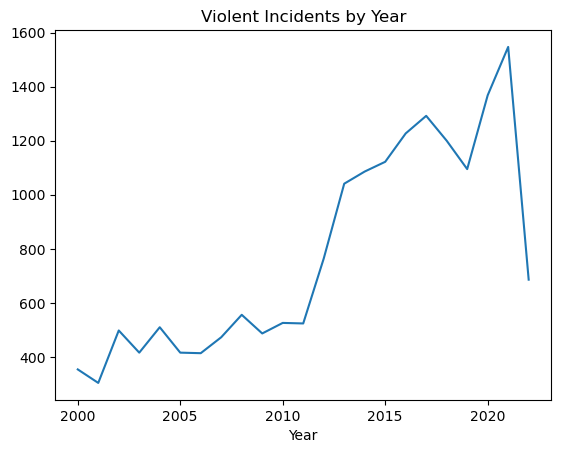

In [326]:
df_eda.groupby(['Year'])['violent_incident'].sum().plot()
plt.title('Violent Incidents by Year')

Text(0, 0.5, 'Violent Incidents')

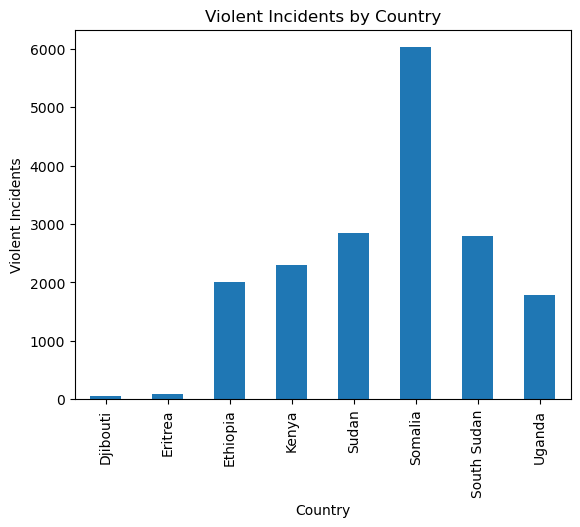

In [327]:
df_eda.groupby(['dis0_code'])['violent_incident'].sum().plot(kind='bar')
plt.title('Violent Incidents by Country')
plt.xticks(np.arange(8), labels=legend_label)
plt.xlabel('Country')
plt.ylabel('Violent Incidents')

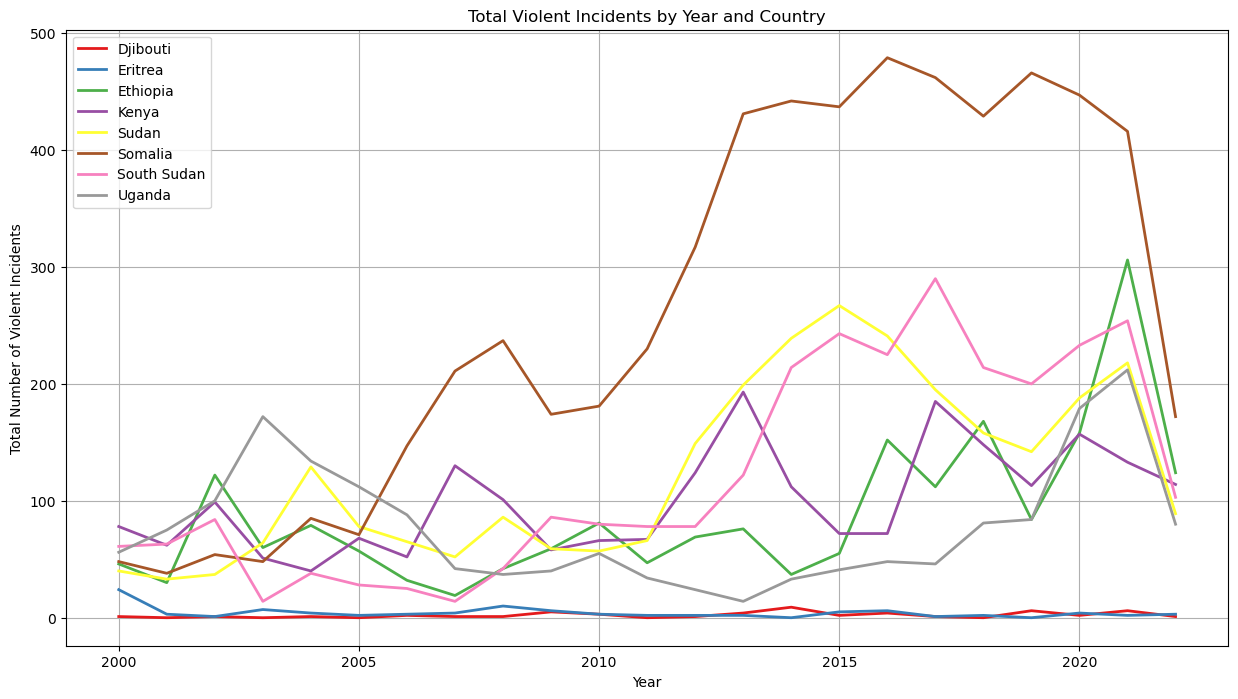

In [328]:
df_eda.groupby(['Year', 'dis0_code'])['violent_incident'].sum().unstack().plot(figsize=(15,8), colormap='Set1', linewidth=2, label=legend_label)
plt.title('Total Violent Incidents by Year and Country')
plt.xlabel('Year')
plt.ylabel('Total Number of Violent Incidents')
plt.grid()
plt.legend(labels = legend_label, loc='best')

In [329]:
# commenting out pairplot because it takes a while to run
#sns.pairplot(df_eda)

<AxesSubplot:>

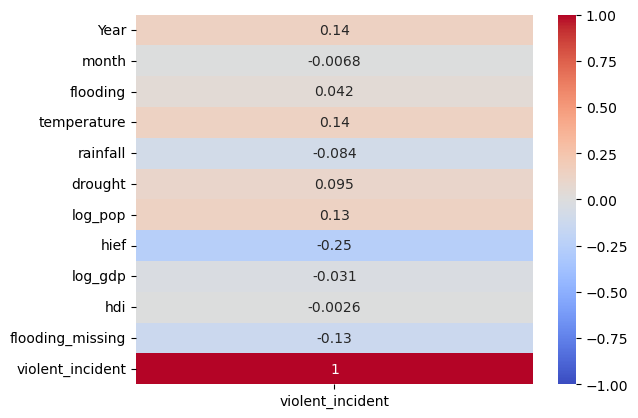

In [330]:
sns.heatmap(df_eda.corr().iloc[:, 11:12], cmap="coolwarm", vmin=-1, vmax=1, annot=True)

In [331]:
import matplotlib.colors as mcolors

drought = df_eda.groupby(['Year'])['drought'].mean()
rainfall = df_eda.groupby(['Year'])['rainfall'].mean()
temperature = df_eda.groupby(['Year'])['temperature'].mean()
flooding = df_eda.groupby(['Year'])['flooding'].mean()
hief = df_eda.groupby(['Year'])['hief'].mean()
pop = df_eda.groupby(['Year'])['log_pop'].mean()
violent = df_eda.groupby(['Year'])['violent_incident'].sum()

countries = df_eda['dis0_code'].unique()
years = df_eda['Year'].unique()
colors = ['whitesmoke', 'gainsboro', 'lightgray', 'silver', 'darkgray', 'gray', 'dimgray', 'midnightblue', 'navy', 'darkblue',
          'mediumblue', 'blue', 'slateblue', 'royalblue', 'cornflowerblue', 'steelblue', 'dodgerblue', 'deepskyblue', 'skyblue', 'lightskyblue',
          'cadetblue', 'darkcyan', 'aqua']

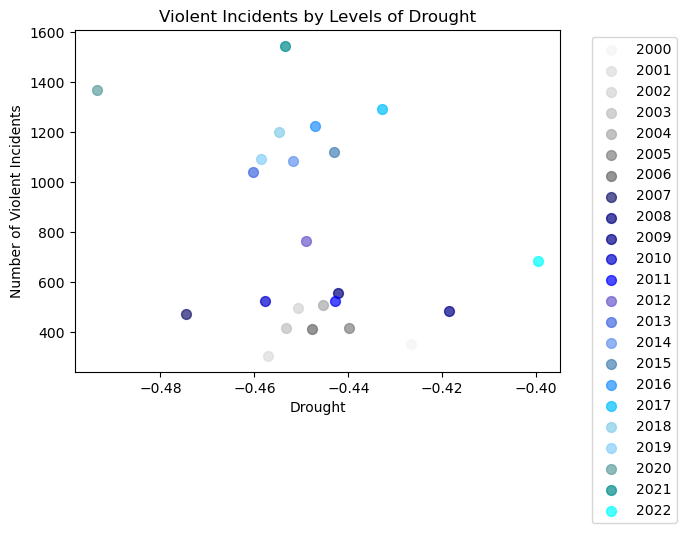

In [332]:
#plot drought
fig, ax = plt.subplots(figsize=(7,5))
for year, color in zip(years, colors):
    i = np.where(years == year)
    ax.scatter(
        drought.iloc[i], violent.iloc[i], label=year,
        s=50, color=color, alpha=0.7
    )
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')   
plt.xlabel('Drought')
plt.ylabel('Number of Violent Incidents')
plt.title('Violent Incidents by Levels of Drought')
plt.tight_layout()
plt.show()

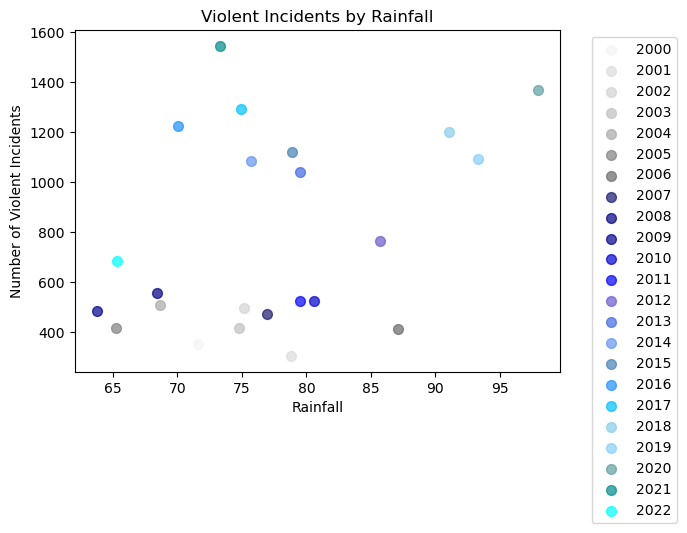

In [333]:
#plot rainfall
fig, ax = plt.subplots(figsize=(7,5))
for year, color in zip(years, colors):
    i = np.where(years == year)
    ax.scatter(
        rainfall.iloc[i], violent.iloc[i], label=year,
        s=50, color=color, alpha=0.7
    )
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')   
plt.xlabel('Rainfall')
plt.ylabel('Number of Violent Incidents')
plt.title('Violent Incidents by Rainfall')
plt.tight_layout()
plt.show()

## There seems to be no correlation with rainfall and conflict. 

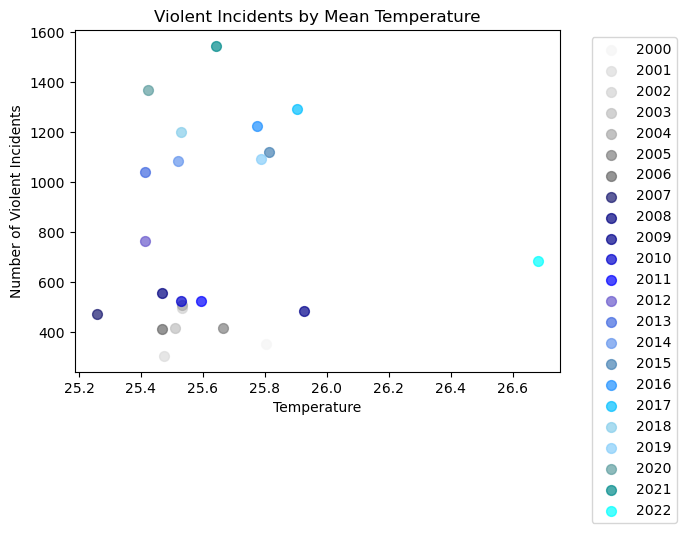

In [334]:
#plot temperature
fig, ax = plt.subplots(figsize=(7,5))
for year, color in zip(years, colors):
    i = np.where(years == year)
    ax.scatter(
        temperature.iloc[i], violent.iloc[i], label=year,
        s=50, color=color, alpha=0.7
    )
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')   
plt.xlabel('Temperature')
plt.ylabel('Number of Violent Incidents')
plt.title('Violent Incidents by Mean Temperature')
plt.tight_layout()
plt.show()

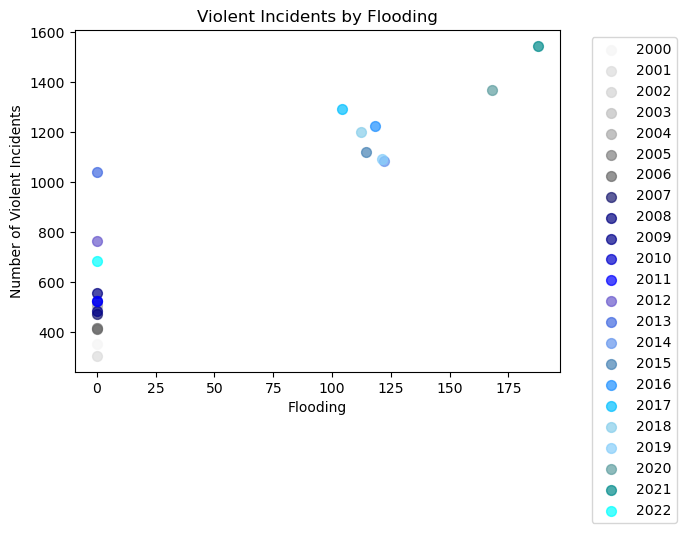

In [335]:
#plot flooding
fig, ax = plt.subplots(figsize=(7,5))
for year, color in zip(years, colors):
    i = np.where(years == year)
    ax.scatter(
        flooding.iloc[i], violent.iloc[i], label=year,
        s=50, color=color, alpha=0.7
    )
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')   
plt.xlabel('Flooding')
plt.ylabel('Number of Violent Incidents')
plt.title('Violent Incidents by Flooding')
plt.tight_layout()
plt.show()

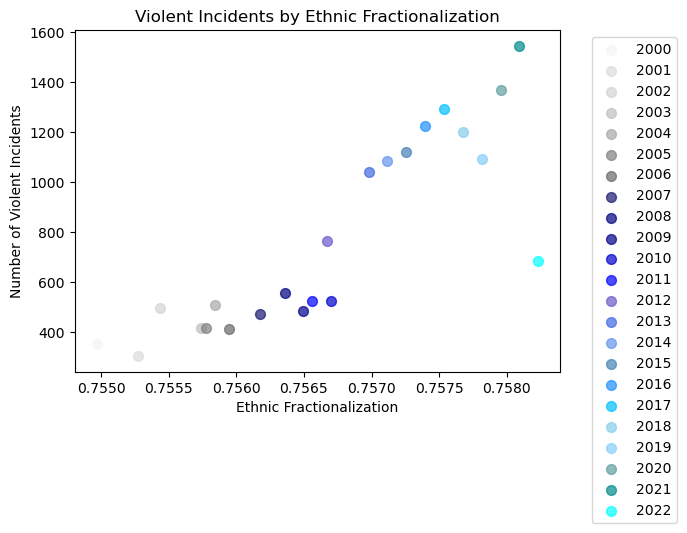

In [336]:
#plot hief
fig, ax = plt.subplots(figsize=(7,5))
for year, color in zip(years, colors):
    i = np.where(years == year)
    ax.scatter(
        hief.iloc[i], violent.iloc[i], label=year,
        s=50, color=color, alpha=0.7
    )
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')   
plt.xlabel('Ethnic Fractionalization')
plt.ylabel('Number of Violent Incidents')
plt.title('Violent Incidents by Ethnic Fractionalization')
plt.tight_layout()
plt.show()

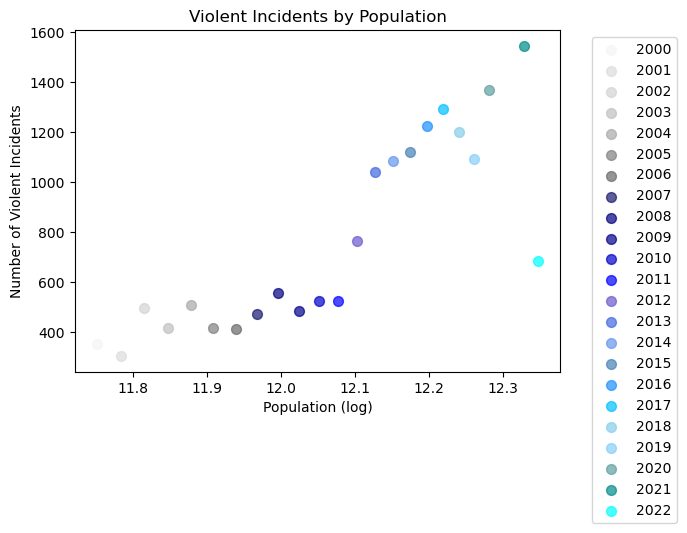

In [337]:
#plot pop
fig, ax = plt.subplots(figsize=(7,5))
for year, color in zip(years, colors):
    i = np.where(years == year)
    ax.scatter(
        pop.iloc[i], violent.iloc[i], label=year,
        s=50, color=color, alpha=0.7
    )
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')   
plt.xlabel('Population (log)')
plt.ylabel('Number of Violent Incidents')
plt.title('Violent Incidents by Population')
plt.tight_layout()
plt.show()

In [44]:
fp = "/Users/andytheo/Desktop/Harvard/Fall 2022/CS 109/Final Project/Horn Shp File/horn_clean.shp"
horn_map = gpd.read_file(fp)
horn_data = pd.read_csv("/Users/andytheo/Desktop/Harvard/Fall 2022/CS 109/Final Project/horn_panel.csv")

horn_data = horn_data.drop(['dis0_code', 'dis0_name', 'dis1_name', 'dis2_name', 'dis1_code'], axis =1)


In [59]:
warnings.filterwarnings('ignore')
scaler = StandardScaler().fit(horn_data[['drought']])

mean_weather_2021 = horn_data[horn_data['Year'] == 2021].groupby('dis2_code')['drought', 'flooding', 'rainfall', 'temperature'].mean()

mean_weathers_all_years = horn_data[horn_data['Year'] != 2021].groupby('dis2_code')['drought', 'flooding', 'rainfall', 'temperature'].mean()
std_weathers_all_years = horn_data[horn_data['Year'] != 2021].groupby('dis2_code')['drought', 'flooding', 'rainfall', 'temperature'].std()

z_scores_2021 = (mean_weather_2021 - mean_weathers_all_years)/std_weathers_all_years

In [52]:
df_merged = pd.merge(horn_map, z_scores_2021, on = ['dis2_code'], how = 'left')
df_merged['neg_ndvi'] = -df_merged['drought']

In [57]:
import warnings
warnings.filterwarnings('ignore')

centroid = df_merged.centroid
df_merged['centroid'] = centroid

flood_extremes = df_merged[df_merged['flooding'] > 0.6]
flood_x = [point.x for point in flood_extremes['centroid']]
flood_y = [point.y for point in flood_extremes['centroid']]

temp_extremes = df_merged[df_merged['temperature'] > 0.6]
temp_x = [point.x for point in temp_extremes['centroid']]
temp_y = [point.y for point in temp_extremes['centroid']]

prec_extremes = df_merged[df_merged['rainfall'] > 0.6]
prec_x = [point.x for point in prec_extremes['centroid']]
prec_y = [point.y for point in prec_extremes['centroid']]


In [61]:
warnings.filterwarnings('ignore')
scaler = StandardScaler().fit(horn_data[['drought']])

#2022

mean_weather_2022 = horn_data[horn_data['Year'] == 2022].groupby('dis2_code')['drought', 'flooding', 'rainfall', 'temperature'].mean()

mean_weathers_all_years = horn_data[horn_data['Year'] != 2022].groupby('dis2_code')['drought', 'flooding', 'rainfall', 'temperature'].mean()
std_weathers_all_years = horn_data[horn_data['Year'] != 2022].groupby('dis2_code')['drought', 'flooding', 'rainfall', 'temperature'].std()

z_scores_2022 = (mean_weather_2022 - mean_weathers_all_years)/std_weathers_all_years

df_merged_2022 = pd.merge(horn_map, z_scores_2022, on = ['dis2_code'], how = 'left')
df_merged_2022['neg_ndvi'] = -df_merged['drought']

centroid_2022 = df_merged_2022.centroid
df_merged_2022['centroid'] = centroid_2022

flood_extremes_2022 = df_merged_2022[df_merged['flooding'] > 0.6]
flood_x_2022 = [point.x for point in flood_extremes_2022['centroid']]
flood_y_2022 = [point.y for point in flood_extremes_2022['centroid']]

temp_extremes_2022 = df_merged_2022[df_merged_2022['temperature'] > 0.6]
temp_x_2022 = [point.x for point in temp_extremes_2022['centroid']]
temp_y_2022 = [point.y for point in temp_extremes_2022['centroid']]

prec_extremes_2022 = df_merged[df_merged_2022['rainfall'] > 0.6]
prec_x_2022 = [point.x for point in prec_extremes_2022['centroid']]
prec_y_2022 = [point.y for point in prec_extremes_2022['centroid']]

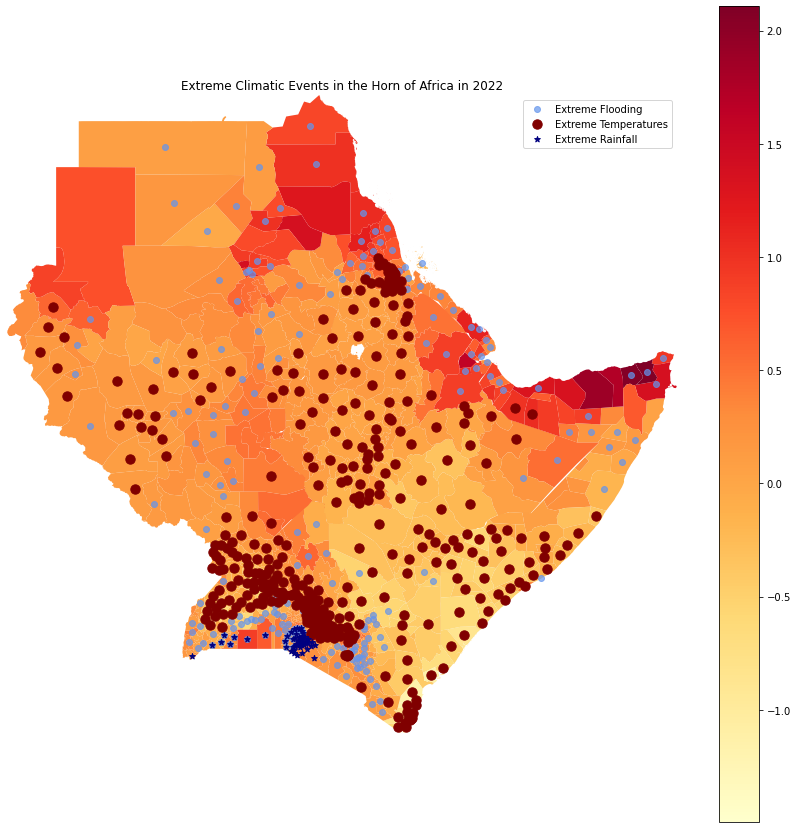

In [62]:
fig, ax = plt.subplots(1, figsize=(15,15))
ax.axis('off')
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

df_merged_2022.plot(column='neg_ndvi', cmap='YlOrRd', linewidth=0.01, ax=ax, edgecolor='0.9', legend = True)
plt.scatter(flood_x_2022, flood_y_2022, marker = 'o', c = 'cornflowerblue', label = "Extreme Flooding", alpha = 0.7)
plt.scatter(temp_x_2022, temp_y_2022, s= 350, marker = '.', c = 'maroon', label = "Extreme Temperatures")
plt.scatter(prec_x_2022, prec_y_2022, marker = '*', c = 'navy', label = "Extreme Rainfall")
plt.title("Extreme Climatic Events in the Horn of Africa in 2022")
plt.legend();

#### Creating maps to understand whether the drought anomalies are concentrated in a single area 

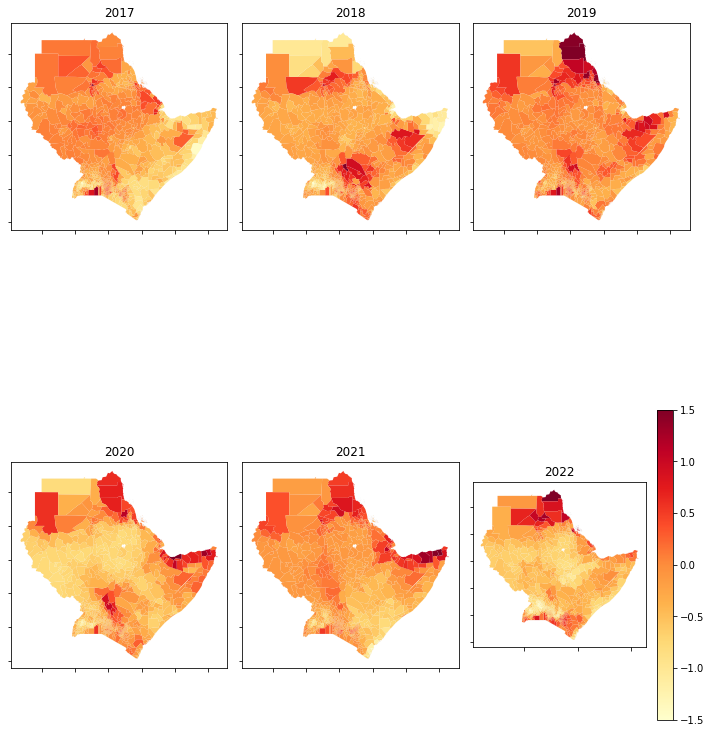

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,15))
axes = axes.ravel()
vmin = -1.5
vmax = 1.5


for i, ax, j in zip(list(np.arange(2017, 2023)), axes, range(6)): 
    #First create the data 
    mean_weather_year = horn_data[horn_data['Year'] == i].groupby('dis2_code')['drought', 'flooding', 'rainfall', 'temperature'].mean()
    
    mean_weathers = horn_data[horn_data['Year'] < i ].groupby('dis2_code')['drought', 'flooding', 'rainfall', 'temperature'].mean()
    std_weathers_all_years = horn_data[horn_data['Year'] < i].groupby('dis2_code')['drought', 'flooding', 'rainfall', 'temperature'].std()
    z_scores = (mean_weather_year - mean_weathers )/std_weathers_all_years
    df_merged_year = pd.merge(horn_map, z_scores, on = ['dis2_code'], how = 'left')
    df_merged_year['neg_ndvi'] = -df_merged_year['drought']
    
    df_merged_year.plot(column='neg_ndvi', cmap='YlOrRd', linewidth=0.01, ax=ax, edgecolor='0.9', legend = False)
    axes[j].set_title(str(i))
    axes[j].xaxis.set_ticklabels([])
    axes[j].yaxis.set_ticklabels([])


sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
cbar = plt.colorbar(sm, location = 'right', shrink = 0.5)

plt.tight_layout();

#### Creating a line chart to understand the patterns of climate anomalies

##### Because flooding has been imputed as 0 when there was missing data, the flooding variable might be displayed in a different pattern here. Given the intense seasonality, we decided to take the moving average of all variables for the past 5 years, except for flooding which is for 1 year. 

The original version is found in the writeup. 

In [67]:
horn_data['date'] =  pd.to_datetime(horn_data['date'])
horn_data['month'] = horn_data['date'].dt.month

#Constructing temperature first 
horn_data['month'] = horn_data['date'].dt.month

#Temp
mean_temp_month = horn_data.groupby('month')['temperature'].mean()
sd_temp_month = horn_data.groupby('month')['temperature'].std()

mean_weather_month_year = horn_data.groupby(['Year', 'month'])['temperature'].mean()

temps = pd.merge(mean_weather_month_year, mean_temp_month, on = ['month'], how = 'left')
temps1 = pd.merge(temps, sd_temp_month, on = ['month'], how = 'left')
temps1['z_score'] = (temps1['temperature_x'] - temps1['temperature_y'])/temps1['temperature']

In [69]:
horn_data['date'] =  pd.to_datetime(horn_data['date'])
horn_data['month'] = horn_data['date'].dt.month
horn_data['neg_ndvi'] = -horn_data['drought']

#Constructing temperature first 

weather_months = horn_data.groupby(['month'], as_index=False).agg(
                      {'temperature':['mean','std'], 'flooding': ['mean', 'std'], 'neg_ndvi': ['mean', 'std'], 
'rainfall': ['mean', 'std']})

new_columns = ['month','mean_temp','std_temp', 'mean_flood', 'std_flood', 'mean_ndvi', 'std_ndvi', 'prec_mean', 'prec_std']
#eather_months.reindex(columns=sorted(result.columns))
#weather_months
weather_months.columns = new_columns
weather_months

cols = ['Year', 'month', 'celsius_mean', 'flooding', 'ndvi', 'precipitation']
horn_month_year = horn_data.groupby(['Year', 'month'], as_index=False).agg(
                      {'temperature':['mean'], 'flooding': ['mean'], 'neg_ndvi': ['mean'], 
'rainfall': ['mean']})
horn_month_year.columns = cols
horn_month_year

merged = pd.merge(horn_month_year, weather_months, on = 'month', how = 'left')

merged['ndvi_zscore'] = (merged['ndvi'] - merged['mean_ndvi'])/merged['std_ndvi']
merged['prec_zscore'] = (merged['precipitation'] - merged['prec_mean'])/merged['prec_std']
merged['temp_zscore'] = (merged['celsius_mean'] - merged['mean_temp'])/merged['std_temp']
merged['flooding_zscore'] = (merged['flooding'] - merged['mean_flood'])/merged['std_flood']

ndvi_rolling = merged['ndvi_zscore'].rolling(60).mean()
prec_rolling = merged['prec_zscore'].rolling(60).mean()
temp_rolling = merged['temp_zscore'].rolling(60).mean()
flood_rolling = merged['flooding_zscore'].rolling(12).mean()

dates = (pd.date_range('2000-01-01', '2022-05-01', freq='M'))
dates_flood = (pd.date_range('2000-01-01', '2022-05-01', freq='M'))

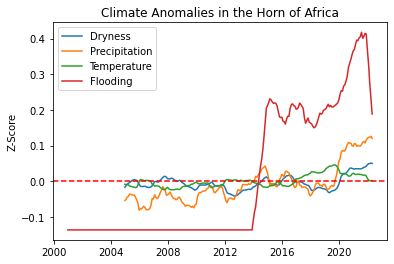

In [71]:
plt.plot(dates, ndvi_rolling, label = "Dryness")
plt.plot(dates, prec_rolling, label = 'Precipitation')
plt.plot(dates, temp_rolling, label = 'Temperature')
plt.plot(dates, flood_rolling, label = 'Flooding')
plt.axhline(y =0, color = 'r', linestyle = '--')
plt.legend();
plt.ylabel("Z-Score")
plt.title("Climate Anomalies in the Horn of Africa");

plt.savefig('horn_anomalies.png')

# PART 3: BASLINE MODEL AND LOGISTIC REGRESSION

### run on monthly data first

In [338]:
panel = df.copy()
# Drop HDI because we do not want to lose somalia from our model
panel = panel.drop(['hdi'],axis=1)

In [339]:
# split into test and trains
train, test = train_test_split(
    panel,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=panel["violent_incident"],
)

X_train = train[['drought', 
                 'flooding',
                 'flood_area',
                 'temperature',
                 'rainfall',
                 'log_pop',
                 'flooding_missing','flood_area_missing',
                 'hief',
                 'log_gdp',
                 'dis0_name_Eritrea',
                 'dis0_name_Kenya', 'dis0_name_Somalia',
                 'dis0_name_South Sudan', 'dis0_name_Sudan',
                 'dis0_name_Uganda']]
X_test = test[['drought', 
                 'flooding',
                  'flood_area',
                 'temperature',
                 'rainfall',
                 'log_pop',
                 'flooding_missing','flood_area_missing',
                 'hief',
                 'log_gdp',
                 'dis0_name_Eritrea',
                 'dis0_name_Kenya', 'dis0_name_Somalia',
                 'dis0_name_South Sudan', 'dis0_name_Sudan',
                 'dis0_name_Uganda']]

y_train = train['violent_incident']
y_test = test['violent_incident']

In [340]:
# calculate componenets of naive model
print("Number of Violent Incidents (Monthly): ", panel['violent_incident'].sum())
print("Number of Total Observations (Monthly): ",  len(panel['violent_incident']))



Number of Violent Incidents (Monthly):  17906
Number of Total Observations (Monthly):  210380


In [341]:
# monthly naive model
prop_fatal_train = train[train['violent_incident'] == 1]['violent_incident'].sum()/len(train)
prop_fatal_test = test[test['violent_incident'] == 1]['violent_incident'].sum()/len(test)

naive_train_acc = 1 - train[train['violent_incident'] == 1]['violent_incident'].sum()/len(train)
naive_test_acc = 1 - test[test['violent_incident'] == 1]['violent_incident'].sum()/len(test)

print(f"Proportion Admitted in training Data: {prop_fatal_train:.2f}")
print("Naive Classification Model Based on Training Proportions")
print(f"\tTrain Accuracy: {naive_train_acc:.4f}")
print(f"\tTest Accuracy: {naive_test_acc:.4f}")

Proportion Admitted in training Data: 0.09
Naive Classification Model Based on Training Proportions
	Train Accuracy: 0.9149
	Test Accuracy: 0.9149


In [342]:
monthly_logit = LogisticRegression(max_iter= 10000).fit(X_train, y_train)

In [343]:
acc_train = monthly_logit.score(X_train , y_train)
acc_test = monthly_logit.score(X_test , y_test)
print(acc_train)
print(acc_test)

0.9210713946192604
0.9217130905979656


## Now try annual data

In [344]:
panel_annual = df_annual.copy()
panel_annual.head()
panel_annual = panel_annual.drop(['hdi'],axis=1)

In [346]:
# split into test and trains
train, test = train_test_split(
    panel_annual,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=panel_annual["violent_incident"],
)

X_train = train[['drought', 
                 'flooding',
                 'flood_area',
                 'temperature',
                 'rainfall',
                 'log_pop',
                 'flooding_missing','flood_area_missing',
                 'hief',
                 'log_gdp',
                 'dis0_name_Eritrea',
                 'dis0_name_Kenya', 'dis0_name_Somalia',
                 'dis0_name_South Sudan', 'dis0_name_Sudan',
                 'dis0_name_Uganda']]
X_test = test[['drought', 
                 'flooding',
                 'flood_area',
                 'temperature',
                 'rainfall',
                 'log_pop',
                 'flooding_missing','flood_area_missing',
                 'hief',
                 'log_gdp',
                 'dis0_name_Eritrea',
                 'dis0_name_Kenya', 'dis0_name_Somalia',
                 'dis0_name_South Sudan', 'dis0_name_Sudan',
                 'dis0_name_Uganda']]

y_train = train['violent_incident']
y_test = test['violent_incident']

In [347]:
# calculate componenets of naive model
print("Number of Violent Incidents (Monthly): ", panel_annual['violent_incident'].sum())
print("Number of Total Observations (Monthly): ",  len(panel_annual['violent_incident']))



Number of Violent Incidents (Monthly):  5587
Number of Total Observations (Monthly):  18055


In [348]:
panel_annual['violent_incident'].sum()/len(panel_annual['violent_incident'])

0.3094433674882304

In [349]:
prop_fatal_train = train[train['violent_incident'] == 1]['violent_incident'].sum()/len(train)
prop_fatal_test = test[test['violent_incident'] == 1]['violent_incident'].sum()/len(test)

naive_train_acc = 1 - train[train['violent_incident'] == 1]['violent_incident'].sum()/len(train)
naive_test_acc = 1 - test[test['violent_incident'] == 1]['violent_incident'].sum()/len(test)

print(f"Proportion Admitted in training Data (Annual): {prop_fatal_train:.2f}")
print("Naive Classification Model Based on Training Proportions(Annual)")
print(f"\tTrain Accuracy (Annual): {naive_train_acc:.4f}")
print(f"\tTest Accuracy (Annual): {naive_test_acc:.4f}")

Proportion Admitted in training Data (Annual): 0.31
Naive Classification Model Based on Training Proportions(Annual)
	Train Accuracy (Annual): 0.6905
	Test Accuracy (Annual): 0.6907


In [350]:
# run cross validation with lasso to determine best logistic model on annual data
# RUN CROSS VALIDATION
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
max_iter = 1000
penalty = "l1"
solver = "liblinear"

np.random.seed(4)
logit_lasso = LogisticRegressionCV(Cs=Cs,
                                   cv=5,
                                   penalty=penalty,
                                   max_iter=max_iter,
                                   solver=solver
)


logit_lasso = logit_lasso.fit(X_train.values, y_train.values) 
logit_lasso_train_acc = logit_lasso.score(X_train.values, y_train) 
logit_lasso_test_acc = logit_lasso.score(X_test.values, y_test) 

In [351]:
logit_lasso.C_

array([10.])

In [352]:
# find important coefs
bool_important_coefs = (logit_lasso.coef_.flatten() != 0)

# find important and non-important coefs 
predictors_important = list(np.array(X_train.columns)[bool_important_coefs]) 
predictors_not_important = np.array(X_train.columns)[~bool_important_coefs] 

In [353]:
# display results
print(
    "The following predictors were deemed important by "
    "'logit_lasso' (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        predictors_not_important,
    )
)

The following predictors were deemed important by 'logit_lasso' (i.e. coef != 0):

	['drought', 'flooding', 'flood_area', 'temperature', 'rainfall', 'log_pop', 'flooding_missing', 'flood_area_missing', 'hief', 'log_gdp', 'dis0_name_Eritrea', 'dis0_name_Kenya', 'dis0_name_Somalia', 'dis0_name_South Sudan', 'dis0_name_Sudan', 'dis0_name_Uganda']


While, the remaining were deemed unimportant (i.e. coef == 0):

	[]


In [354]:
# get final accuracies
logit_best = LogisticRegression(C = 10,  max_iter= 100000).fit(X_train[predictors_important],y_train)


In [356]:
acc_train = logit_best.score(X_train[predictors_important] , y_train)
acc_test = logit_best.score(X_test[predictors_important] , y_test)

print(
    "\nThe  accuracies for 'logistic_simple' are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        acc_train, acc_test
    )
)


The  accuracies for 'logistic_simple' are:

	Train	0.7571
	TEST	0.7519


In [357]:
# get false positive false negative
predicted=logit_best.predict(X_test)
cm=confusion_matrix(y_test, predicted)
cm

array([[2247,  247],
       [ 649,  468]], dtype=int64)

In [358]:
fnr = cm[1][0] / (cm[1][0] + cm[1][1])
fpr = cm[0][1] / (cm[0][1] + cm[0][0])
print(fnr)
print(fpr)

0.5810205908683975
0.09903769045709704


In [359]:
attributes_coefficients = pd.DataFrame(np.transpose(logit_best.coef_), index=X_train.columns, columns=['Coefficient Estimate (Annual Model)']) 
attributes_coefficients

,Coefficient Estimate (Annual Model)
drought,-1.042e+00
flooding,-8.211e-05
flood_area,-5.132e-06
temperature,7.513e-02
rainfall,-7.094e-03
log_pop,6.518e-01
flooding_missing,-4.443e-01
flood_area_missing,-3.330e-01
hief,-3.013e+00
log_gdp,9.183e-02


# PART 4: RANDOM FOREST

In [361]:
#drop unneeded columns
df_rf = df.copy()
df_rf = df_rf.drop(columns=["Year", "dis2_code", "date", "dis2_name", "dis1_code", "dis1_name", "dis0_code", "dis0_name", "flood_area", "month", "demonstration", "flood_area_missing", "hdi"])
df_rf.head()

,flooding,temperature,drought,rainfall,violent_incident,log_pop,flooding_missing,hief,log_gdp,dis0_name_Eritrea,dis0_name_Ethiopia,dis0_name_Kenya,dis0_name_Somalia,dis0_name_South Sudan,dis0_name_Sudan,dis0_name_Uganda
0,0.0,30.973,-0.118,5.679,0,10.96,1,0.651,7.739,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,31.105,-0.114,7.705,0,10.96,1,0.651,7.739,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,35.054,-0.112,21.646,0,10.96,1,0.651,7.739,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,36.275,-0.118,17.655,0,10.96,1,0.651,7.739,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,34.866,-0.110,1.875,0,10.96,1,0.651,7.739,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [362]:
# set X as all predictor columns y as violent incident column
X=df_rf.drop(columns=["violent_incident"])
y=df_rf["violent_incident"]

In [363]:
# split into test and train datasets
train_size = 0.8
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size, random_state=random_state)

## Perform Cross Validation Across Number of Trees

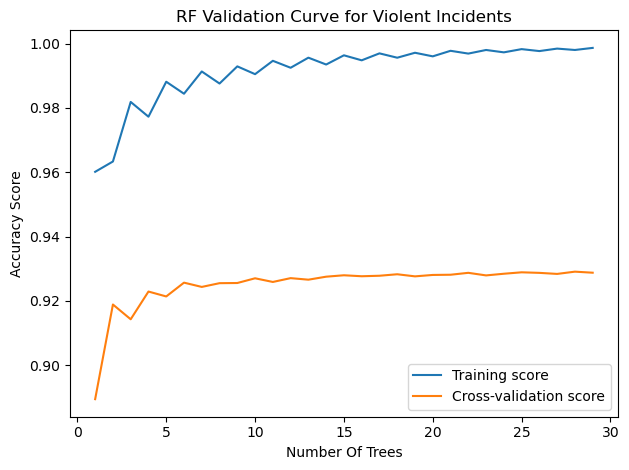

In [364]:
# create range of values for parameter
param_range_est = np.arange(1, 30)

# calculate accuracy on training and test set using range of parameter values
train_scores_est, test_scores_est = validation_curve(RandomForestClassifier(), 
                                             X_train, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range_est,
                                             cv=3, 
                                             scoring="accuracy",
                                             n_jobs=-1)


# calculate mean for training and test set scores
train_mean_est = np.mean(train_scores_est, axis=1)
test_mean_est = np.mean(test_scores_est, axis=1)

# plot mean accuracy scores for training and test sets
plt.plot(param_range_est, train_mean_est, label="Training score")
plt.plot(param_range_est, test_mean_est, label="Cross-validation score")

# create plot
plt.title("RF Validation Curve for Violent Incidents")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

## Perform Cross Validation Across Tree Depth 

#### From the previous analysis, it is observed that 6 trees are the optimal for our RF Model. 

In [365]:
# set number of trees as the best values from cross-validation
n_estimators = np.argmax(test_mean_est)+1

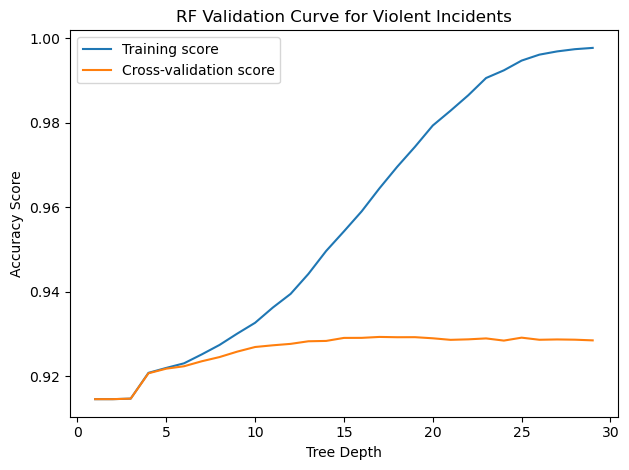

In [366]:
# create range of values for parameter
param_range_dep = np.arange(1, 30)

# calculate accuracy on training and test set using range of parameter values
train_scores_dep, test_scores_dep = validation_curve(RandomForestClassifier(n_estimators=n_estimators), 
                                             X_train, 
                                             y_train, 
                                             param_name="max_depth", 
                                             param_range=param_range_dep,
                                             cv=3, 
                                             scoring="accuracy",
                                             n_jobs=-1)


# calculate mean for training and test set scores
train_mean_dep = np.mean(train_scores_dep, axis=1)
test_mean_dep = np.mean(test_scores_dep, axis=1)

# plot mean accuracy scores for training and test sets
plt.plot(param_range_dep, train_mean_dep, label="Training score")
plt.plot(param_range_dep, test_mean_dep, label="Cross-validation score")

# create plot
plt.title("RF Validation Curve for Violent Incidents")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [367]:
# set tree depth as the best values from cross-validation
tree_depth = np.argmax(test_mean_dep)+1

In [368]:
# fit RF for violent incidents
random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=tree_depth, max_features="sqrt")
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, n_estimators=28)

In [369]:
# calculate baseline accuracies
baseline = ['Monthly: Baseline', (len(y_train) - y_train.sum()) / len(y_train), (len(y_test) - y_test.sum()) / len(y_test)]

# calculate and print accuracy scores
random_forest_train_score = random_forest.score(X_train, y_train)
random_forest_test_score = random_forest.score(X_test, y_test)

rf = ['Monthly: Depth-{} and {} trees'.format(tree_depth, n_estimators), random_forest_train_score, random_forest_test_score]

In [370]:
# identify top nodes of each tree for each predictor for demonstrations
feature_num = np.arange(len(X_train.columns))
top_predictors_rf = pd.DataFrame(np.zeros((len(feature_num), 1)), columns=["Number of Times Feature is Top Node"])

for i in range(n_estimators):
    top_predictors_rf.iloc[random_forest.estimators_[i].tree_.feature[0], 0] = top_predictors_rf.iloc[random_forest.estimators_[i].tree_.feature[0], 0] + 1
    
top_predictors_rf = top_predictors_rf.set_axis([X_train.columns])

In [371]:
# calculate feature importance using MDI
feature_names = random_forest.feature_names_in_

mdi_importances = pd.Series(
    random_forest[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

In [372]:
# calculate confusion matrix
y_pred = random_forest.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

fpr = cm[1][0] / (cm[1][0] + cm[1][1])
fnr = cm[0][1] / (cm[0][1] + cm[0][0])

print("The false positive rate is {:.4f} and the false negative rate is {:.4f}".format(fpr, fnr))

The false positive rate is 0.6920 and the false negative rate is 0.0115


In [373]:
#drop unneeded columns
df_annual = pd.read_csv('horn_panel_annual.csv')
df_annual_rf = df_annual.drop(columns=["dis2_code", "Year", "flood_area", "demonstration", "flood_area_missing", "hdi"])
df_annual_rf.head()

,drought,flooding,temperature,rainfall,violent_incident,log_pop,flooding_missing,hief,log_gdp,dis0_name_Eritrea,dis0_name_Kenya,dis0_name_Somalia,dis0_name_South Sudan,dis0_name_Sudan,dis0_name_Uganda
0,-0.086,0.0,34.492,8.160,0,8.792,1.0,0.651,7.739,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.088,0.0,34.115,8.200,0,8.703,1.0,0.651,7.784,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.089,0.0,33.619,7.967,0,8.754,1.0,0.651,7.829,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.088,0.0,33.194,7.024,0,8.719,1.0,0.651,7.874,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.087,0.0,33.594,7.073,0,8.792,1.0,0.651,7.919,0.0,0.0,0.0,0.0,0.0,0.0


In [374]:
# set X_a as all predictor columns, y_a as violent incident column
X_a=df_annual_rf.drop(columns=["violent_incident"])
y_a=df_annual_rf["violent_incident"]

In [375]:
# split into test and train datasets
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a, y_a, train_size = train_size, random_state=random_state)

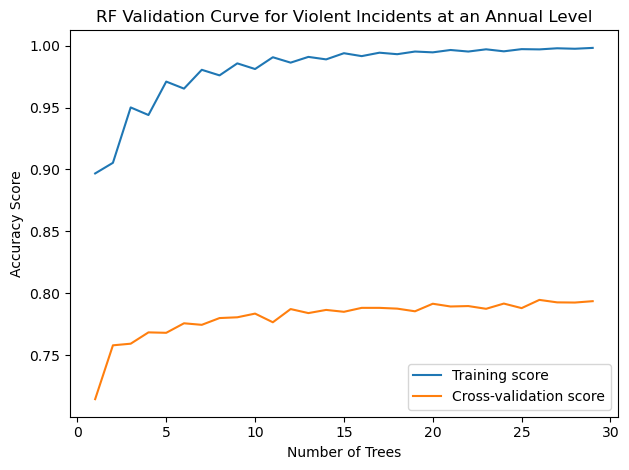

In [376]:
# calculate accuracy on training and test set using range of parameter values
train_scores_est_a, test_scores_est_a = validation_curve(RandomForestClassifier(), 
                                             X_a_train, 
                                             y_a_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range_est,
                                             cv=3, 
                                             scoring="accuracy",
                                             n_jobs=-1)


# calculate mean for training and test set scores
train_mean_est_a = np.mean(train_scores_est_a, axis=1)
test_mean_est_a = np.mean(test_scores_est_a, axis=1)

# plot mean accuracy scores for training and test sets
plt.plot(param_range_est, train_mean_est_a, label="Training score")
plt.plot(param_range_est, test_mean_est_a, label="Cross-validation score")

# create plot
plt.title("RF Validation Curve for Violent Incidents at an Annual Level")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [377]:
#find best value for number of trees based on above graph
n_estimators_a = np.argmax(test_mean_est_a)+1

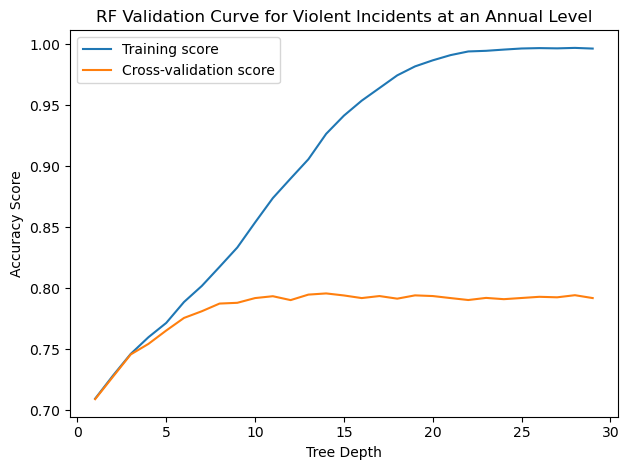

In [378]:
# calculate accuracy on training and test set using range of parameter values
train_scores_dep_a, test_scores_dep_a = validation_curve(RandomForestClassifier(n_estimators=n_estimators_a), 
                                             X_a_train, 
                                             y_a_train, 
                                             param_name="max_depth", 
                                             param_range=param_range_dep,
                                             cv=3, 
                                             scoring="accuracy",
                                             n_jobs=-1)


# calculate mean for training and test set scores
train_mean_dep_a = np.mean(train_scores_dep_a, axis=1)
test_mean_dep_a = np.mean(test_scores_dep_a, axis=1)

# plot mean accuracy scores for training and test sets
plt.plot(param_range_dep, train_mean_dep_a, label="Training score")
plt.plot(param_range_dep, test_mean_dep_a, label="Cross-validation score")

# create plot
plt.title("RF Validation Curve for Violent Incidents at an Annual Level")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [379]:
# set tree depth as the best values from cross-validation
tree_depth_a = np.argmax(test_mean_dep_a)+1

In [387]:
# fit RF for violent incidents
random_forest_a = RandomForestClassifier(n_estimators=n_estimators_a, max_depth=tree_depth_a, max_features="sqrt")
random_forest_a.fit(X_a_train, y_a_train)

RandomForestClassifier(max_depth=14, n_estimators=26)

In [388]:
# calculate baseline accuracies
baseline_a = ['Annual: baseline', (len(y_a_train) - y_a_train.sum()) / len(y_a_train), (len(y_a_test) - y_a_test.sum()) / len(y_a_test)]

# calculate and print accuracy scores
random_forest_train_score_a = random_forest_a.score(X_a_train, y_a_train)
random_forest_test_score_a = random_forest_a.score(X_a_test, y_a_test)

rf_a = ['Annual: depth-{} and {} trees'.format(tree_depth_a, n_estimators_a), random_forest_train_score_a, random_forest_test_score_a]
results = [baseline, rf, baseline_a, rf_a]
results_df = pd.DataFrame(results, columns=['Classifier', 'Training accuracy', 'Test accuracy'])
results_df

,Classifier,Training accuracy,Test accuracy
0,Monthly: Baseline,0.915,0.916
1,Monthly: Depth-17 and 28 trees,0.961,0.931
2,Annual: baseline,0.692,0.685
3,Annual: depth-14 and 26 trees,0.912,0.793


In [389]:
# identify top nodes of each tree for each predictor for demonstrations
feature_num_a = np.arange(len(X_a_train.columns))
top_predictors_rf_a = pd.DataFrame(np.zeros((len(feature_num_a), 1)), columns=["Number of Times Feature is Top Node"])

for i in range(n_estimators_a):
    top_predictors_rf_a.iloc[random_forest_a.estimators_[i].tree_.feature[0], 0] = top_predictors_rf_a.iloc[random_forest_a.estimators_[i].tree_.feature[0], 0] + 1
    
top_predictors_rf_a = top_predictors_rf_a.set_axis([X_a_train.columns])

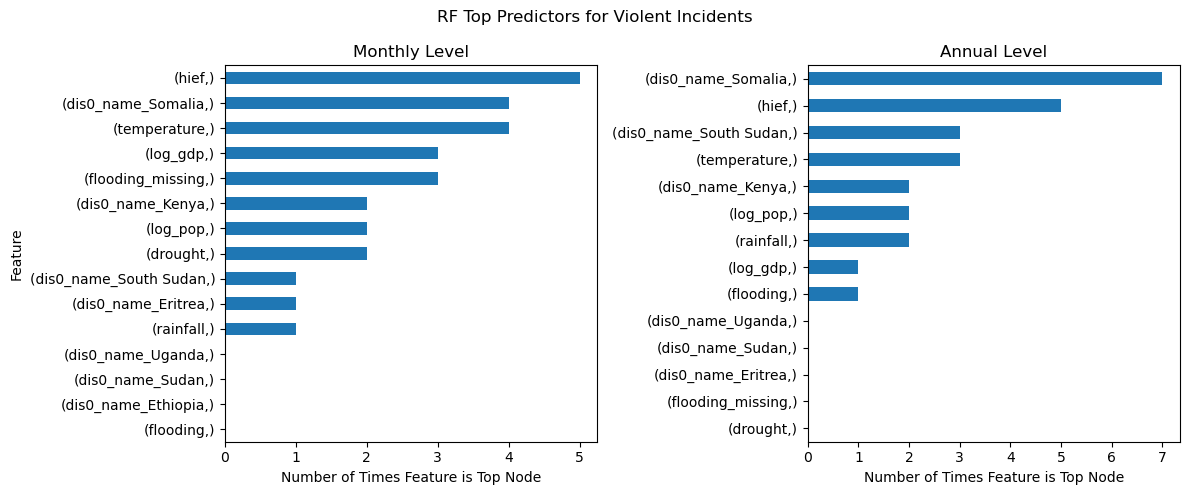

In [390]:
# plot top predictors
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

top_predictors_rf.sort_values(by=['Number of Times Feature is Top Node'], ascending=True).plot.barh(ax=ax[0])
ax[0].set_title("Monthly Level")
ax[0].set_xlabel("Number of Times Feature is Top Node")
ax[0].set_ylabel("Feature")
ax[0].legend('', frameon=False)

top_predictors_rf_a.sort_values(by=['Number of Times Feature is Top Node'], ascending=True).plot.barh(ax=ax[1])
ax[1].set_title("Annual Level")
ax[1].set_xlabel("Number of Times Feature is Top Node")
ax[1].legend('', frameon=False)

fig.suptitle('RF Top Predictors for Violent Incidents')
plt.tight_layout()

In [394]:
# calculate confusion matrix
y_pred_a = random_forest_a.predict(X_a_test)
cm_a = confusion_matrix(y_a_test, y_pred_a)

#calculate FPR and FNR
fnr_a = cm_a[1][0] / (cm_a[1][0] + cm_a[1][1])
fpr_a = cm_a[0][1] / (cm_a[0][1] + cm_a[0][0])

print("The false positive rate is {:.4f} and the false negative rate is {:.4f}".format(fpr_a, fnr_a))

The false positive rate is 0.0724 and the false negative rate is 0.5000


In [392]:
# calculate feature importance using MDI
feature_names_a = random_forest_a.feature_names_in_

mdi_importances_a = pd.Series(
    random_forest_a[-1].feature_importances_, index=feature_names_a
).sort_values(ascending=True)

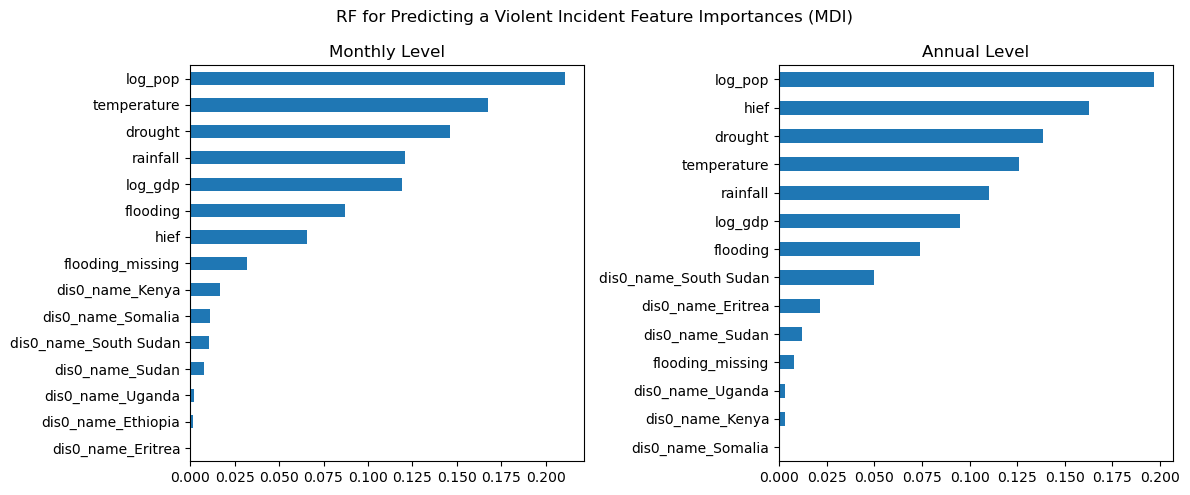

In [393]:
# plot feature importance for MDI for both monthly and annual levels
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

mdi_importances.plot.barh(ax=ax[0])
ax[0].set_title("Monthly Level")
ax[0].figure.tight_layout()

mdi_importances_a.plot.barh(ax=ax[1])
ax[1].set_title("Annual Level")
ax[1].figure.tight_layout()

fig.suptitle('RF for Predicting a Violent Incident Feature Importances (MDI)')
plt.tight_layout()

# PART 5: BAGGING

In [2]:
data_annual = pd.read_csv("/Users/andytheo/Desktop/Harvard/Fall 2022/CS 109/Final Project/horn_panel_annual.csv")

In [3]:
dropped_cols = ['dis2_code', 'flood_area_missing', 'demonstration', 'flood_area', 'Year', 'hdi']

random_state = 42

#Splitting our dataset into train and test
data_train, data_test = train_test_split(data_annual, random_state = random_state, train_size = 0.8)
data_train = data_train.drop(dropped_cols, axis =1)
data_test = data_test.drop(dropped_cols, axis =1)

X_train = data_train.drop('violent_incident', axis =1)
X_test = data_test.drop('violent_incident', axis =1)
y_train = data_train['violent_incident']
y_test = data_test['violent_incident']

In [4]:
#Splitting for validation for Bagging
data_train80, data_val = train_test_split(data_train, random_state = random_state, train_size = 0.8)

X_train80 = data_train80.drop('violent_incident', axis =1)
X_val = data_val.drop('violent_incident', axis =1)
y_train80 = data_train80['violent_incident']
y_val = data_val['violent_incident']

In [5]:
#Creating functions to extract predictions for the bagged models and the OOB error

def get_prediction(df):
    return np.mean(df, axis=1)>0.5

def get_oob_prediction(preds, oob_counts):
    oob_idx = oob_counts > 0
    oob_vote = np.sum(preds[oob_idx], axis=1)/oob_counts[oob_idx]
    return oob_vote>0.5

In [6]:
n_trees = 100

training_accuracies_cv = []
val_accuracies_cv = []

depths = np.arange(4, 100, 2)

for i in depths:
#Setting The Decision Tree Classifier
    model = DecisionTreeClassifier(max_depth=i)
#Because we are dealing with classification, we will obtain the majority voting of every row


#Initializing variables
    predictions_train80 = np.zeros(shape = (data_train80.shape[0], n_trees))
    predictions_val  = np.zeros(shape = (data_val.shape[0],  n_trees))

    predictions_oob = np.zeros(shape = (data_train80.shape[0], n_trees))
    oob_samples_count = np.zeros(shape = (data_train80.shape[0], )) # how many times a sample is in oob

    oob_accuracies = []
#Conduct bootstraping iterations
    for i in range(n_trees):
        temp = data_train80.sample(frac=1, replace = True)
        boot_y = temp['violent_incident']
        boot_X = temp.drop(['violent_incident'], axis=1)
    
    # Train a decision tree
        model.fit(boot_X, boot_y)  
        predictions_train80[:,i] = model.predict(X_train80) 
        predictions_val[:,i] = model.predict(X_val)
    
        # Get OOB samples
        oob_mask = ~np.isin(data_train80.index, temp.index)
        oob_temp = data_train80[oob_mask]
        X_oob = oob_temp.drop(['violent_incident'], axis=1)
        y_oob = oob_temp['violent_incident']
        oob_p = model.predict(X_oob)
        predictions_oob[oob_mask, i] = oob_p # Update prediction results of this tree
        oob_samples_count[oob_mask] += 1 # Increase the count of this sample being OOB
    
    training_accuracies_cv.append(accuracy_score(y_train80, get_prediction(predictions_train80)))
    val_accuracies_cv.append(accuracy_score(y_val, get_prediction(predictions_val)))

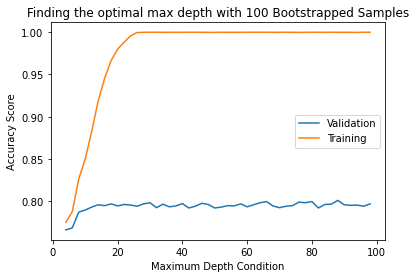

In [7]:
plt.plot(depths, val_accuracies_cv, label = "Validation")
plt.plot(depths, training_accuracies_cv, label = "Training")
plt.legend()
plt.ylabel("Accuracy Score")
plt.xlabel("Maximum Depth Condition")
plt.title("Finding the optimal max depth with 100 Bootstrapped Samples");

In [8]:
best_depth = depths[np.argmax(val_accuracies_cv)]
print("The best depth to be used for bagging is ", best_depth)

The best depth to be used for bagging is  88


In [9]:
#Using the best depth for the our bagging estimators. 
best_depth = 88
#Setting The Decision Tree Classifier
model = DecisionTreeClassifier(max_depth=best_depth)
#Because we are dealing with classification, we will obtain the majority voting of every row


#Initializing variables
predictions_train = np.zeros( shape = (data_train.shape[0], n_trees))
predictions_test  = np.zeros( shape = (data_test.shape[0],  n_trees))

predictions_oob = np.zeros(shape = (data_train.shape[0], n_trees))
oob_samples_count = np.zeros(shape = (data_train.shape[0], )) # how many times a sample is in oob

oob_accuracies = []
#Conduct bootstraping iterations
for i in range(n_trees):
    temp = data_train.sample(frac=1, replace=True)
    boot_y = temp['violent_incident']
    boot_X = temp.drop(['violent_incident'], axis=1)
    
    # Train a decision tree
    model.fit(boot_X, boot_y)  
    predictions_train[:,i] = model.predict(X_train)   
    predictions_test[:,i] = model.predict(X_test)
    
    # Get OOB samples
    oob_mask = ~np.isin(data_train.index, temp.index)
    oob_temp = data_train[oob_mask]
    X_oob = oob_temp.drop(['violent_incident'], axis=1)
    y_oob = oob_temp['violent_incident']
    #Predict the OOB Samples
    oob_p = model.predict(X_oob)
    #Checking if the dataset is correct
    predictions_oob[oob_mask, i] = oob_p # Update prediction results of this tree
    oob_samples_count[oob_mask] += 1 # Increase the count of this sample being OOB

In [10]:
acc_bagging_training = 100*accuracy_score(y_train, get_prediction(predictions_train))
acc_bagging_testing  = 100*accuracy_score(y_test, get_prediction(predictions_test))
acc_bagging_oob = 100*accuracy_score(y_train, get_oob_prediction(predictions_oob, oob_samples_count))

In [11]:
print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Test Set \t: {:0.2f}%".format(acc_bagging_testing))
print("Bagging: \tAccuracy, OOB Set \t: {:0.2f}%".format(acc_bagging_oob))

Bagging: 	Accuracy, Training Set 	: 100.00%
Bagging: 	Accuracy, Test Set 	: 80.06%
Bagging: 	Accuracy, OOB Set 	: 79.82%


In [12]:
y_hat_bagging = model.predict_proba(X_test)
conf_matrix_bagging = pd.crosstab(np.array(y_test), model.predict(X_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

fpr_bagging = conf_matrix_bagging[1][0]/conf_matrix_bagging['All'][0]*100
fnr_bagging = conf_matrix_bagging[0][1]/conf_matrix_bagging['All'][1]*100


print("Bagging: \tFalse Positive Rate, Training Set \t: {:0.2f}%".format(fpr_bagging))
print("Bagging: \tFalse Negative Rate, Test Set \t: {:0.2f}%".format(fnr_bagging))

Bagging: 	False Positive Rate, Training Set 	: 20.74%
Bagging: 	False Negative Rate, Test Set 	: 46.22%


# PART 6 XGBoost


#### Performing a cross validaion to find the best number of estimators. 

In [15]:
#Cross validation for the AdaBoost Classifier using 27 different trees
#THIS CODE WILL TAKE A WHILE TO RUN
learning_rate = 0.3
n_estimators = np.arange(1, 800, 25)

#Setting a depth of 2
depth = 2

val_scores = []
train_scores = []

for i in n_estimators: 
    ab = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), n_estimators = i, 
                           learning_rate = learning_rate, 
                            random_state = random_state, algorithm = 'SAMME.R')
    
    cross_val = cross_val_score(ab, X_train, y_train, cv = 10, 
                               scoring = 'accuracy')
    
    val_scores.append(np.mean(cross_val))  
    
best_estimators = n_estimators[np.argmax(val_scores)]

The best number of estimators is 176


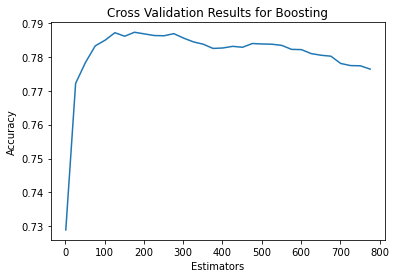

In [16]:
plt.plot(n_estimators, val_scores, label = 'Train')
plt.xlabel("Estimators")
plt.ylabel("Accuracy")
plt.title("Cross Validation Results for Boosting")

print("The best number of estimators is", best_estimators)

#### Fit the adaboost with the best number of estimators

In [17]:
#Given how much time Boosting needs to run, we are hard-coding the estimator here in case we need to run this again
best_estimators = 176
learning_rate = 0.3
depth = 2
best_boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), 
                                n_estimators = best_estimators, 
                               learning_rate = learning_rate, 
                               random_state = random_state, algorithm = 'SAMME.R').fit(X_train, y_train)

In [34]:
train_score = best_boost.score(X_train, y_train)
test_score_best_boost = best_boost.score(X_test, y_test)

print("The train score is", train_score, 'and test score is', test_score)

The train score is 0.8082941013569648 and test score is 0.79


In [21]:
#Extracting the predictions based on the best number of estimators
predictions_test_boosting = best_boost.predict(X_test)
conf_matrix_boosting = pd.crosstab(np.array(y_test), best_boost.predict(X_test), margins=True, rownames=['Actual'], colnames=['Predicted'])


fpr_boosting = round(conf_matrix_boosting[1][0]/conf_matrix_boosting['All'][0]*100,2)
fnr_boosting = round(conf_matrix_boosting[0][1]/conf_matrix_boosting['All'][1]*100,2)

In [22]:
print("The false positive rate for Boosting is", fpr_boosting, "and false negative rate is", fnr_boosting)
conf_matrix_boosting

The false positive rate for Boosting is 7.28 and false negative rate is 51.93


Predicted,0,1,All
Actual,,,
0,2293,180,2473
1,591,547,1138
All,2884,727,3611


#### Permutation Analysis
Based on the best model to understand if the features identified under the Random Forest is similar to what was found under AdaBoost. 

In [27]:
perm = PermutationImportance(best_boost, random_state= random_state, n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

Weight,Feature
0.0825 ± 0.0041,hief
0.0529 ± 0.0097,log_pop
0.0421 ± 0.0063,temperature
0.0236 ± 0.0076,drought
0.0170 ± 0.0043,log_gdp
0.0114 ± 0.0071,rainfall
0.0080 ± 0.0045,dis0_name_Eritrea
0.0061 ± 0.0028,dis0_name_Sudan
0.0057 ± 0.0022,dis0_name_South Sudan
0.0047 ± 0.0021,flooding


#### Dropping the variables that permutation did not deem as important and re-rerunning the analysis

In [28]:
variables_important = ['log_pop', 'rainfall', 'temperature', 
                       'hief', 'log_gdp', 'drought', 'dis0_name_Eritrea', 
                      'dis0_name_Sudan']

X_train_imp = X_train[variables_important]
X_test_imp = X_test[variables_important]

In [29]:
#Re run the boosting algorithm 
boost_imp = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), 
                                n_estimators = best_estimators, 
                               learning_rate = learning_rate, 
                               random_state = random_state, algorithm = 'SAMME.R').fit(X_train_imp, y_train)

In [36]:
train_score = round(boost_imp.score(X_train_imp, y_train),2)
test_score_imp = round(boost_imp.score(X_test_imp, y_test),2)

print("The train score for the Boosting Algorithm with dropped variables is", train_score, 'and test score is', test_score)

predictions_test = boost_imp.predict(X_test_imp)
conf_matrix = confusion_matrix(y_test, predictions_test)

fpr= round(100*confusion_matrix(y_test, predictions_test)[0, 1]/ (confusion_matrix(y_test, predictions_test)[0, 1] + confusion_matrix(y_test, predictions_test)[0, 0]),2)

fnr= round(100*confusion_matrix(y_test, predictions_test)[1, 0]/ (confusion_matrix(y_test, predictions_test)[1, 1] + confusion_matrix(y_test, predictions_test)[1, 0]),2)

print("Boosting (Important Variables): \tAccuracy, Test Set \t: {:0.2f}%".format(test_score_imp))
print("Boosting (Important Variables): \tFalse Positive Rate \t: {:0.2f}%".format(fpr))
print("Boosting (Important Variables): \tFalse Negative Rate \t: {:0.2f}%".format(fnr))
print("Boosting (No Omission): \tAccuracy, Test Set \t: {:0.2f}%".format(test_score_best_boost))
print("Boosting (No Omission): \tFalse Positive Rate \t: {:0.2f}%".format(fpr_boosting))
print("Boosting (No Omission): \tFalse Negative Rate \t: {:0.2f}%".format(fnr_boosting))

The train score for the Boosting Algorithm with dropped variables is 0.81 and test score is 0.79
Boosting (Important Variables): 	Accuracy, Test Set 	: 0.79%
Boosting (Important Variables): 	False Positive Rate 	: 8.01%
Boosting (Important Variables): 	False Negative Rate 	: 50.79%
Boosting (No Omission): 	Accuracy, Test Set 	: 0.79%
Boosting (No Omission): 	False Positive Rate 	: 7.28%
Boosting (No Omission): 	False Negative Rate 	: 51.93%


The Boosting Algorithm with the dropped variables performs slightly better, however still worse than the bagging estimation. 

#### ROC Analysis between Boosting & Bagging

In [37]:

model.predict_proba(X_test)
fpr_bagging, tpr_bagging, thresholds = roc_curve(y_test, y_hat_bagging[:,1])

fpr_boosting, tpr_boosting, thresholds = roc_curve(y_test, best_boost.predict_proba(X_test)[:,1])
fpr_imp_boosting, tpr_imp_boosting, thresholds = roc_curve(y_test, boost_imp.predict_proba(X_test_imp)[:,1])

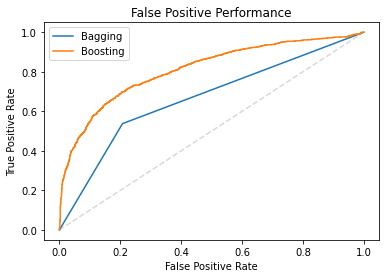

<Figure size 432x288 with 0 Axes>

In [42]:

x=np.arange(0,100)/100

plt.plot(x,x,'--',color="gray",alpha=0.3)
plt.plot(fpr_bagging,tpr_bagging, label = "Bagging")
plt.plot(fpr_imp_boosting, tpr_imp_boosting, label = "Boosting")
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("False Positive Performance")
plt.show()

plt.savefig('roc_boosting_bagging.png')